In [1]:
!git clone https://github.com/nhoues/Water-Level-Forecasting.git

Cloning into 'Water-Level-Forecasting'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 144 (delta 59), reused 118 (delta 36), pack-reused 0
Receiving objects: 100% (144/144), 15.20 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
cd Water-Level-Forecasting 

/kaggle/working/Water-Level-Forecasting


# SET UP

In [3]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from models import * 
from utils import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'



# Feature Engineering

In [4]:
data = pd.read_csv('preprocessed_data.csv')
hydrometric_stations = data.ID.unique().tolist()
hydrometric_stations.remove('05RE003')

In [5]:
test_station = data[data['ID'] == '05RE003']

test_station['Water Level_previous'] = test_station["Value"].shift(1) 
test_station['WL_pct'] = 10000*(test_station["Value"]  - test_station['Water Level_previous'] ) / test_station['Water Level_previous']
test_station['WL_mean_12'] = test_station['WL_pct'].rolling(12).mean()
test_station['WL_mean_18'] = test_station['WL_pct'].rolling(18).mean()
test_station['WL_mean_24'] = test_station['WL_pct'].rolling(24).mean()
test_station['WL_std_12']  = test_station['WL_pct'].rolling(12).std()
test_station['WL_std_24']  = test_station['WL_pct'].rolling(24).std()
test_station['WL_lag_12']  = test_station['WL_pct'].shift(12)
test_station['WL_lag_6']   = test_station['WL_pct'].shift(6)

test_station['Date'] = pd.to_datetime(test_station['Date'])
test_station['dayOfweek'] =  test_station['Date'].dt.dayofweek
test_station['month'] =  test_station['Date'].dt.month

test_station.dropna( inplace = True )



In [6]:
test_station = test_station[test_station['Date']>'2018-01-01']
train_data_target = test_station[test_station['Date']< '2019-06-01']
val_data_target   = test_station[test_station['Date']> '2019-06-01']
print(train_data_target.shape)
print(val_data_target.shape)

(515, 17)
(213, 17)


In [7]:
all_stations_train = []
all_stations_test  = []

for station in hydrometric_stations : 

  hydro = data[data['ID'] == station]

  hydro['Water Level_previous'] = hydro["Value"].shift(1) 
  hydro['WL_pct'] = 10000*(hydro["Value"]  - hydro['Water Level_previous'] ) / hydro['Water Level_previous']
  hydro['WL_mean_12'] = hydro['WL_pct'].rolling(12).mean()
  hydro['WL_mean_18'] = hydro['WL_pct'].rolling(18).mean()
  hydro['WL_mean_24'] = hydro['WL_pct'].rolling(24).mean()
  hydro['WL_std_12']  = hydro['WL_pct'].rolling(12).std()
  hydro['WL_std_24']  = hydro['WL_pct'].rolling(24).std()
  hydro['WL_lag_12']  = hydro['WL_pct'].shift(12)
  hydro['WL_lag_6']  = hydro['WL_pct'].shift(6)

  hydro['Date'] = pd.to_datetime(hydro['Date'])
  hydro['dayOfweek'] =  hydro['Date'].dt.dayofweek
  hydro['month'] =  hydro['Date'].dt.month
  
  hydro.dropna( inplace = True )

  seq_len = len(hydro)
  all_stations_train.append(hydro.iloc[:int(0.8*seq_len)])
  all_stations_test.append(hydro.iloc[int(0.8*seq_len):] )

In [8]:
num_feat = ['WL_pct','WL_mean_12','WL_mean_18','WL_mean_18','WL_mean_24','WL_std_12','WL_std_24','WL_lag_12','WL_lag_6']
cat_feat = ['dayOfweek','month']
embbedded_size  = [(7,4),(12,6)]

# Train in tow years of Target Station 

In [9]:
# Hyperparameters 
train_batch_size = 64
valid_batch_size = 32
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 5e-4
device = torch.device('cuda')
window_size = 30  
path = 'LSTM_Staked_target_without_transfer_learning.pth'
verbose = False

train_dataset = hydro_dataset(train_data_target  , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data_target    , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)
val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True 
)

--------- Epoch 0 ---------
 train_loss  = 0.9946431070566177
 val_loss  = 2.3076960978408656
--------- Epoch 10 ---------
 train_loss  = 0.8787719458341599
 val_loss  = 2.219873490432898
--------- Epoch 20 ---------
 train_loss  = 0.6230669692158699
 val_loss  = 2.340820726007223
Eraly Stopping on Epoch 27
Best Loss =  2.1330549841125808


# Train on all data 

In [10]:
train_data = pd.concat(all_stations_train)
val_data   = pd.concat(all_stations_test)
filter = train_data.groupby('ID')['WL_pct'].agg(['mean']) 
filter = filter[filter['mean']<.002]
filter = filter[filter['mean']>-0.01]
train_data = train_data[train_data.ID.isin(filter.index)]
val_data = val_data[val_data.ID.isin(filter.index)]

In [11]:
# Hyperparameters 
train_batch_size = 256
valid_batch_size = 128
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-3
device = torch.device('cuda')
window_size = 30  
path = 'LSTM_Staked.pth'
verbose = False

train_dataset = hydro_dataset_transfer_learning(train_data , hydrometric_stations , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset_transfer_learning(val_data   , hydrometric_stations , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)

val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True 
)

--------- Epoch 0 ---------
 train_loss  = 1.8774501578396103
 val_loss  = 2.0199814422062703
--------- Epoch 10 ---------
 train_loss  = 1.5059626156905568
 val_loss  = 1.9207768431032735
Eraly Stopping on Epoch 19
Best Loss =  1.8918997730938643


# Transfer Learning to the target station 

In [12]:
# Hyperparameters 
train_batch_size = 64
valid_batch_size = 32
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 5e-5
device = torch.device('cuda')
window_size = 30  
path = 'LSTM_Staked_target_with_transfer_learning.pth'
verbose = False

train_dataset = hydro_dataset(train_data_target  , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data_target    , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)
stacked_lstm.load_state_dict(torch.load('LSTM_Staked.pth'))
val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True 
)

--------- Epoch 0 ---------
 train_loss  = 1.1371384114027023
 val_loss  = 2.1780927876631417
--------- Epoch 10 ---------
 train_loss  = 0.8928396664559841
 val_loss  = 2.3983886167407036
Eraly Stopping on Epoch 11
Best Loss =  2.1780927876631417


# Result Evaluation 

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
val_data_target = val_data_target.iloc[window_size:]

stacked_lstm.load_state_dict(torch.load('LSTM_Staked_target_with_transfer_learning.pth'))
pred = predict( stacked_lstm , valid_dataset )
val_data_target['WL_pct_hat'] = pred / 10000
val_data_target['WL_pct_hat_transfer_learning'] = val_data_target['Water Level_previous'] * (1+val_data_target['WL_pct_hat'] )

stacked_lstm.load_state_dict(torch.load('LSTM_Staked_target_without_transfer_learning.pth'))
pred = predict( stacked_lstm , valid_dataset )
val_data_target['WL_pct_hat'] = pred / 10000
val_data_target['WL_hat_stacked_lstm'] = val_data_target['Water Level_previous'] * (1+val_data_target['WL_pct_hat'] )

fig = make_subplots()
fig.add_trace(go.Scatter( y=val_data_target['Value'].values, name='Ground Truth values'))
fig.add_trace(go.Scatter( y=val_data_target['WL_hat_stacked_lstm'].values ,name='stacked_lstm predictions'))
fig.add_trace(go.Scatter( y=val_data_target['WL_pct_hat_transfer_learning'].values ,name='transfer learning to stacked_lstm predictions'))

fig.show()

100%|██████████| 3/3 [00:00<00:00, 30.78it/s]


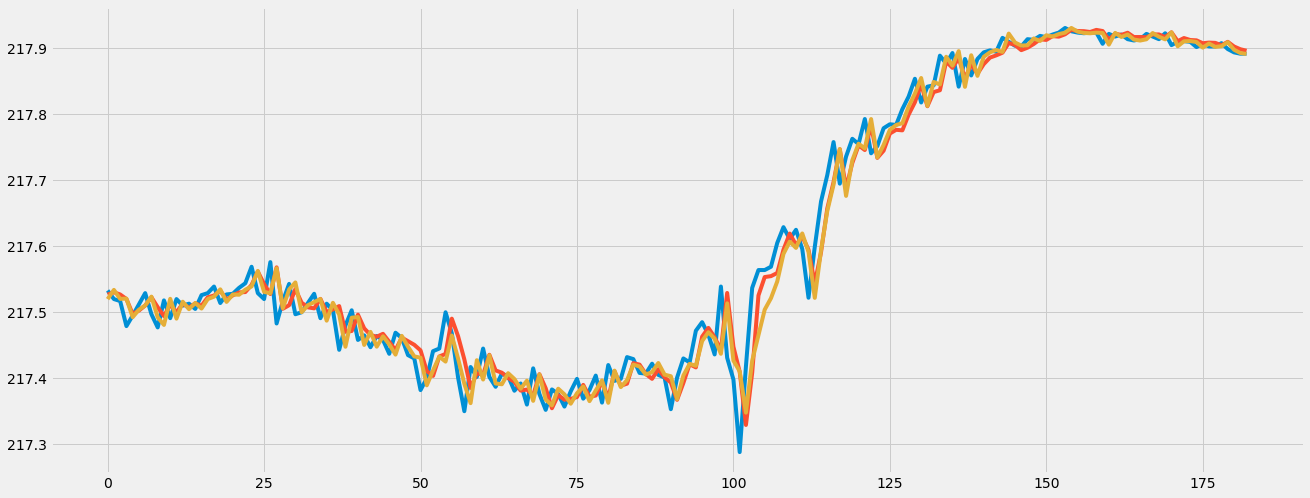

In [15]:
plt.plot( val_data_target['Value'].values, label='Ground Truth values')
plt.plot( val_data_target['WL_hat_stacked_lstm'].values ,label='stacked_lstm predictions')
plt.plot( val_data_target['WL_pct_hat_transfer_learning'].values ,label='transfer learning to stacked_lstm predictions')

plt.show()

In [16]:
print('LSTM Stacked Model Results')
print('MSE = ' , mean_squared_error(val_data_target['Value'], val_data_target['WL_hat_stacked_lstm']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data_target['Value'], val_data_target['WL_hat_stacked_lstm'])))
print('mean_absolute_error = ', mean_absolute_error(val_data_target['Value'], val_data_target['WL_hat_stacked_lstm']))
print('mean_absolute_percentage_error = ', mean_absolute_percentage_error(val_data_target['Value'], val_data_target['WL_hat_stacked_lstm']))

LSTM Stacked Model Results
MSE =  0.0010562313874135309
RMSE =  0.03249971365125439
mean_absolute_error =  0.02304112113662214
mean_absolute_percentage_error =  0.010590924705539658


In [17]:
print('Tranfer leanring LSTM Stacked Model Results')
print('MSE = ' , mean_squared_error(val_data_target['Value'], val_data_target['WL_pct_hat_transfer_learning']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data_target['Value'], val_data_target['WL_pct_hat_transfer_learning'])))
print('mean_absolute_error = ', mean_absolute_error(val_data_target['Value'], val_data_target['WL_pct_hat_transfer_learning']))
print('mean_absolute_percentage_error = ', mean_absolute_percentage_error(val_data_target['Value'], val_data_target['WL_pct_hat_transfer_learning']))

Tranfer leanring LSTM Stacked Model Results
MSE =  0.001078647047009676
RMSE =  0.03284276247531069
mean_absolute_error =  0.023230029331858325
mean_absolute_percentage_error =  0.01067769016800522
